In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, stencil

# Anisotropic diffusion with slowly varying diffusion tensor using the FTCS scheme
### Anisotropic diffusion
In this notebook, we will implement the Forward-Time Central-Space (FTCS) discretization of the anisotropic diffusion equation in the slowly varying approximation. The anisotropic diffusion equation describes the diffusion of a species in a medium where the diffusion rate depends on the direction of diffusion. The equation can be written as:
$$ \frac{\partial \rho}{\partial t} = \nabla \cdot (D \nabla \rho) $$
where $\rho$ is the density of the diffusing species and $D$ is the diffusion tensor

### Slowly varying approximation
In two dimensions, the anisotropic diffusion tensor can be represented in Cartesian coordinates as

$$ D = \begin{pmatrix} D^{xx} & D^{xy} \\ D^{xy} & D^{yy} \end{pmatrix} $$

Expanding the anisotropic diffusion equation yields:

$$\begin{align} \frac{\partial \rho}{\partial t} &= \frac{\partial}{\partial x}\left(D^{xx}\frac{\partial \rho}{\partial x} + D^{xy}\frac{\partial \rho}{\partial y}\right) + \frac{\partial}{\partial y}\left(D^{xy}\frac{\partial \rho}{\partial x} + D^{yy}\frac{\partial \rho}{\partial y}\right) \\
  & = D^{xx}\frac{\partial^2 \rho}{\partial x^2} + D^{yy}\frac{\partial^2 \rho}{\partial y^2} + 2D^{xy}\frac{\partial^2 \rho}{\partial x \partial y}  + \left(\frac{\partial D^{xx}}{\partial x} + \frac{\partial D^{xy}}{\partial y}\right) \frac{\partial \rho}{\partial x} + \left(\frac{\partial D^{xy}}{\partial x} + \frac{\partial D^{yy}}{\partial y}\right)\frac{\partial \rho}{\partial y} \nonumber\end{align}$$

For simplicity, we assume here that the diffusion tensor varies slowly enough that the spatial derivatives of $D$ can be neglected, leading to the slowly varying approximation

$$\frac{\partial \rho}{\partial t} = D^{xx}\frac{\partial^2 \rho}{\partial x^2} + D^{yy}\frac{\partial^2 \rho}{\partial y^2} + 2D^{xy}\frac{\partial^2 \rho}{\partial x \partial y} $$

See the associated jupyter notebook for an implicit BTCS discretization of the full anisotropic diffusion equation.

### FTCS discretization for slowly varying anisotropic diffusion
The Forward-Time Central-Space (FTCS) discretization of the slowly varying anisotropic diffusion equation can be straightforwardly written down as
$$\begin{align} \rho_{i,j}^{n+1} &= u_{i,j}^n + \Delta t \left( D_{i,j}^{xx}\,\frac{\rho_{i+1,j}^n - 2\rho_{i,j}^n + \rho_{i-1,j}^n}{(\Delta x)^2} + D_{i,j}^{yy}\,\frac{\rho_{i,j+1}^n - 2\rho_{i,j}^n + \rho_{i,j-1}^n}{(\Delta y)^2} + \right. \nonumber \\
  & \qquad \qquad \qquad \qquad \left.+ 2D_{i,j}^{xy}\,\frac{\rho_{i+1,j+1}^n - \rho_{i+1,j-1}^n - \rho_{i-1,j+1}^n + \rho_{i-1,j-1}^n}{4\Delta x \Delta y} \right) 
\end{align}$$
This update step can be readily implemented using numba stencils as follows. 

In [2]:

@stencil
def diffusion_stencil(rho, dt, dx, dy, D_xx, D_yy, D_xy):
  """Stencil function for slowly varying anisotropic diffusion"""
  # Compute spatial derivatives using central differences
  rho_xx = (rho[0, 1] - 2*rho[0, 0] + rho[0, -1]) / (dx**2)
  rho_yy = (rho[1, 0] - 2*rho[0, 0] + rho[-1, 0]) / (dy**2)
  rho_xy = (rho[1, 1] - rho[1, -1] - rho[-1, 1] + rho[-1, -1]) / (4*dx*dy)
  
  # Apply anisotropic diffusion
  return rho[0, 0] + \
    dt * ( D_xx[0, 0] * rho_xx + D_yy[0, 0] * rho_yy + 2 * D_xy[0, 0] * rho_xy )

@njit
def apply_boundaries(rho):
  """Apply von Neumann boundary conditions (zero flux)"""
  rho[0, :]  = rho[1, :]
  rho[-1, :] = rho[-2, :]
  rho[:, 0]  = rho[:, 1]
  rho[:, -1] = rho[:, -2]
  return rho

@njit
def ftcs_step(rho, dt, dx, dy, D_xx, D_yy, D_xy):
  """Perform one step of the FTCS scheme using Numba stencil"""
  # Apply diffusion stencil to the grid (handles interior points)
  rho_new = diffusion_stencil(rho, dt, dx, dy, D_xx, D_yy, D_xy)
  
  # Apply boundary conditions
  rho_new = apply_boundaries(rho_new)
  
  return rho_new


### Simulation setup
We will use a domain $[0,1]^2$ with zero flux Neumann boundary conditions, which requires using one ghost cell layer on each side of the domain. We set up a diffusion tensor in polar coordinates, where the radial component is strongly suppressed in comparison to the angular component. We then simulate the diffusion of a circular blob.

dt =  4.056874952712051e-05  (dtmax =  4.056874952712051e-05 )
Image @ step 00123, t = 0.00499
Image @ step 00246, t = 0.00998
Image @ step 00369, t = 0.01497
Image @ step 00492, t = 0.01996


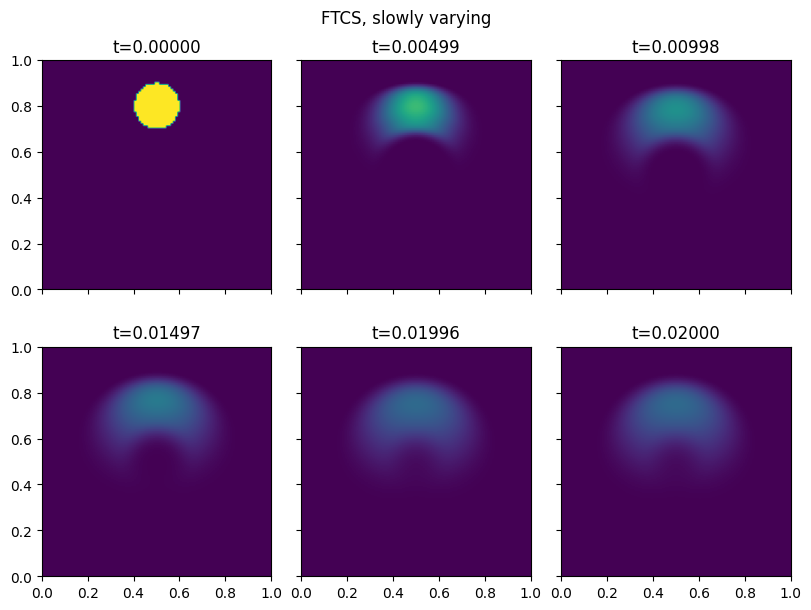

In [3]:
# Parameters
nx, ny = 100, 100  # Grid points
dx, dy = 1.0/(nx-1), 1.0/(ny-1)  # Grid spacing

CFLfac = 1.0

tmax = 0.02
plot_interval = 50  # Save every 50th step

# Create grid
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)

# Initial condition: disk with radius 0.1 centered at (0.5, 0.8)
rho = np.zeros((ny, nx))
disk_center = (0.5, 0.8)
disk_radius = 0.1

for i in range(nx):
    for j in range(ny):
        if ((X[j,i] - disk_center[0])**2 + (Y[j,i] - disk_center[1])**2) < disk_radius**2:
            rho[j,i] = 1.0

# Precompute diffusion tensor components (angular anisotropy)
# Center point 
center_x, center_y = 0.5, 0.5

# Diffusion coefficients
D_r = 0.01      # Radial diffusion  (weaker)
D_theta = 1.0   # Angular diffusion (stronger)

# Calculate relative positions and angles from center
X_rel = X - center_x
Y_rel = Y - center_y
Theta = np.arctan2(Y_rel, X_rel)

# Compute diffusion tensor components in Cartesian coordinates
D_xx = D_r * np.cos(Theta)**2 + D_theta * np.sin(Theta)**2
D_yy = D_r * np.sin(Theta)**2 + D_theta * np.cos(Theta)**2
D_xy = (D_r - D_theta) * np.sin(Theta) * np.cos(Theta)

# determine time step from eigenvalues
alpha_xx = 2*D_xx/dx**2
alpha_yy = 2*D_yy/dy**2
alpha_xy = 2*D_xy/dx/dy

lambda1 = 0.5 * (alpha_xx + alpha_yy + np.sqrt((alpha_xx - alpha_yy)**2 + 4*alpha_xy**2))
lambda2 = 0.5 * (alpha_xx + alpha_yy - np.sqrt((alpha_xx - alpha_yy)**2 + 4*alpha_xy**2))

dtmax = np.min(1/(2*D_xx/dx**2 + 2*D_yy/dy**2 + np.abs(D_xy)/dx/dy).flatten())
dt    = CFLfac * dtmax
print('dt = ', dt, ' (dtmax = ', dtmax, ')')

# Determine interval for plots
plot_interval = round(tmax/dt)//4

# compute time evolution
t       = 0.0
step    = 0
frames  = [rho.copy()]
frame_t = [t]
while t < tmax:
  dt = np.minimum( dt, tmax-t)
  rho = ftcs_step(rho, dt, dx, dy, D_xx, D_yy, D_xy)
  t  += dt
  step += 1
  if step % plot_interval == 0:
    frames.append(rho.copy())
    frame_t.append(t)
    print(f"Image @ step {step:05d}, t = {t:.5f}")

frames.append(rho.copy())
frame_t.append(t)

# Create visualization
n = len(frames)//2
fig, ax = plt.subplots(2,n,figsize=(8, 6),sharex=True,sharey=True, layout='constrained')
plt.suptitle(f'FTCS, slowly varying')
for i in range(len(frames)):
  a  = ax[i//n,i%n]
  im = a.imshow(frames[i], origin='lower', extent=[0, 1, 0, 1], cmap='viridis', vmin=0, vmax=1.0)
  a.set_title(f't={frame_t[i]:.5f}')
